# Model_generalization

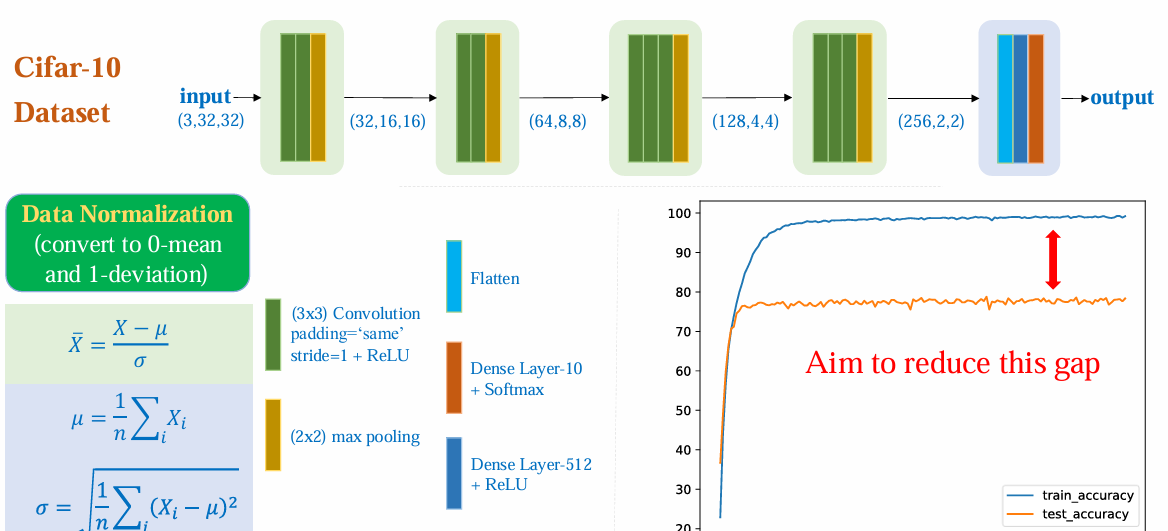

In [10]:
# Baseline:
# zScore Normalization
# 4 blocks (2, 2, 3, 3)
# Relu, He
# Adam _lr = 1e-3

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import torchvision

In [11]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Data

In [12]:
batch_size = 256
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])

train_set = torchvision.datasets.CIFAR10(
    root = './../data_cifar10',
    train=True,
    download=True,
    transform=transform
)

val_set = torchvision.datasets.CIFAR10(
    root = './../data_cifar10',
    train=False,
    download=True,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size,
    shuffle=True, num_workers=2,
)

test_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size,
    shuffle=True, num_workers=2,
)

# Model

In [13]:
class CNNModel(nn.Module):
    def __init__(self, n_classes = 10):
        super(CNNModel, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU()
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=1, padding='same'),
            nn.ReLU(),
        )
        self.conv_layer4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_layer5 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding='same'),
            nn.ReLU(),
        )
        self.conv_layer6 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding='same'),
            nn.ReLU(),
        )
        self.conv_layer7 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv_layer8 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
        )
        self.conv_layer9 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
        )
        self.conv_layer10 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*2*2, 512),
            nn.ReLU(),
            nn.Linear(512, n_classes)
        )
    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = self.conv_layer5(x)
        x = self.conv_layer6(x)
        x = self.conv_layer7(x)
        x = self.conv_layer8(x)
        x = self.conv_layer9(x)
        x = self.conv_layer10(x)
        out = self.classifier(x)

        return out

In [14]:
model = CNNModel(10)
model.to(device)
print(model)

CNNModel(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv_layer4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv_layer6): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv_layer7): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1

# Train

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
def evaluete(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            running_correct += (predicted == labels).sum().item()
        accuracy = 100 * running_correct / total
        test_loss = test_loss / len(test_loader)
        return test_loss, accuracy



In [17]:
train_losses = []
train_accuracies = []
test_losses =[]
test_accuracies = []
epochs_max = 20

In [18]:
for epoch in range(epochs_max):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        running_correct += (predicted==labels).sum().item()
    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i+1)
    test_loss, test_accuracy = evaluete(model, test_loader, criterion)

    print(f"Epoch [{epoch + 1}/{epochs_max}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/20], Loss: 1.9086, Accuracy: 25.88%, Test Loss: 1.6780, Test Accuracy: 35.92%
Epoch [2/20], Loss: 1.4259, Accuracy: 46.33%, Test Loss: 1.2722, Test Accuracy: 52.90%
Epoch [3/20], Loss: 1.1738, Accuracy: 57.15%, Test Loss: 1.0817, Test Accuracy: 60.97%
Epoch [4/20], Loss: 0.9797, Accuracy: 64.84%, Test Loss: 1.0535, Test Accuracy: 62.23%
Epoch [5/20], Loss: 0.8522, Accuracy: 69.57%, Test Loss: 0.8661, Test Accuracy: 69.24%
Epoch [6/20], Loss: 0.7355, Accuracy: 73.75%, Test Loss: 0.8119, Test Accuracy: 72.14%
Epoch [7/20], Loss: 0.6498, Accuracy: 77.02%, Test Loss: 0.7769, Test Accuracy: 73.73%
Epoch [8/20], Loss: 0.5827, Accuracy: 79.56%, Test Loss: 0.7411, Test Accuracy: 74.81%
Epoch [9/20], Loss: 0.5051, Accuracy: 82.31%, Test Loss: 0.7426, Test Accuracy: 76.40%
Epoch [10/20], Loss: 0.4431, Accuracy: 84.44%, Test Loss: 0.7088, Test Accuracy: 77.26%
Epoch [11/20], Loss: 0.3964, Accuracy: 86.02%, Test Loss: 0.7472, Test Accuracy: 76.89%
Epoch [12/20], Loss: 0.3432, Accuracy: 87

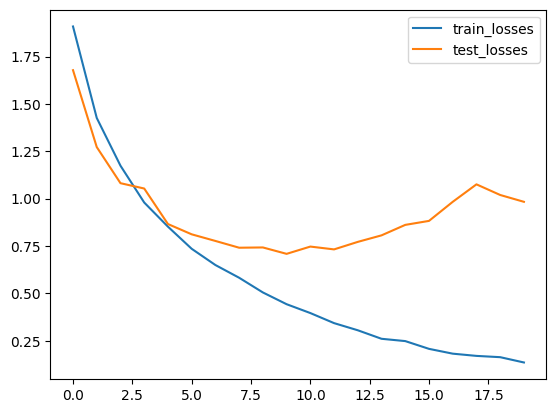

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

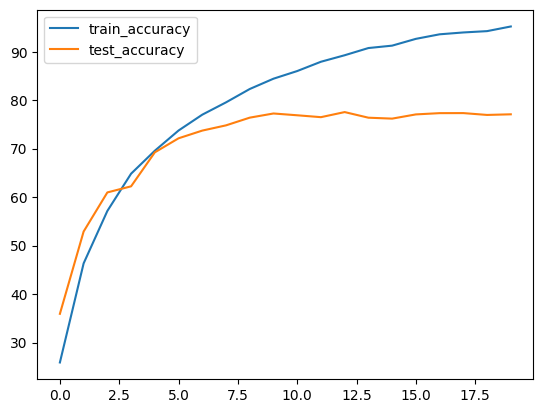

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()